In [ ]:
# https://www.kaggle.com/code/akensert/panda-optimized-tiling-tf-data-dataset/notebook
# To dos: 
# 1. Tile images (256x256)
# 2. Filter images (i.e. remove ones with mostly white space)
# 3. Mask - red/green for cancer/non cancer

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 
from tqdm.notebook import tqdm
import skimage.io
import tensorflow as tf
import math
import glob

In [3]:
data = pd.read_csv('train.csv')
input_path = 'train_images/'
data.head(3)

image_id data_provider  isup_grade gleason_score
0  0005f7aaab2800f6170c399693a96917    karolinska           0           0+0
1  000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
2  0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4

### Reading image

In [4]:
def read_image(image_path, resize_ratio=1):
    
    if not(isinstance(image_path, str)):
        # if tensor with byte string
        image_path = image_path.numpy().decode('utf-8')
        
    # image_level_1 = skimage.io.MultiImage(image_path)[1]
    image_level_1 = skimage.io.MultiImage(image_path)[0]

    if resize_ratio != 1:
        new_w = int(image_level_1.shape[1]*resize_ratio)
        new_h = int(image_level_1.shape[0]*resize_ratio)
        image_level_1 = cv2.resize(
            image_level_1, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    return image_level_1

image = read_image(input_path + data.image_id[0] + '.tiff')

In [5]:
read_image(input_path + data.image_id[0] + '.tiff')

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

### Masking Image

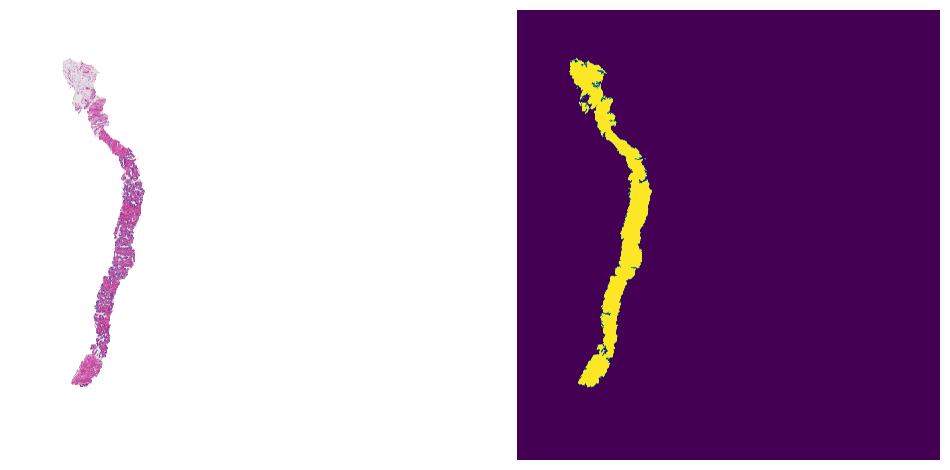

In [6]:
def _mask_tissue(image, kernel_size=(7, 7), gray_threshold=220):
    """Masks tissue in image. Uses gray-scaled image, as well as
    dilation kernels and 'gap filling'
    """
    # Define elliptic kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    # Convert rgb to gray scale for easier masking
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Now mask the gray-scaled image (capturing tissue in biopsy)
    mask = np.where(gray < gray_threshold, 1, 0).astype(np.uint8)
    # Use dilation and findContours to fill in gaps/holes in masked tissue
    mask = cv2.dilate(mask, kernel, iterations=1)
    contour, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contour:
        cv2.drawContours(mask, [cnt], 0, 1, -1)
    return mask


fig, axes = plt.subplots(1, 2, figsize=(12, 12))

mask = _mask_tissue(image)

axes[0].imshow(image)
axes[1].imshow(mask)
axes[0].axis('off')
axes[1].axis('off');

### Computing Patch Coordinates

helper functions:
- _pad_image(...)
- _transpose_image(...)
- _get_tissue_parts_indices(...)
- _get_tissue_subparts_coords(...)
- _eval_and_append_xy_coords(...)

main function:
- compute_coords(image, patch_size, ...)

In [14]:
def _pad_image(image, pad_len, pad_val):
    """Pads inputted image, accepts both 
    2-d (mask) and 3-d (rgb image) arrays
    """
    if image is None:
        return None
    elif image.ndim == 2:
        return np.pad(
            image, ((pad_len, pad_len), (pad_len, pad_len)), pad_val)
    elif image.ndim == 3:
        return np.pad(
            image, ((pad_len, pad_len), (pad_len, pad_len), (0, 0)), pad_val)
    return None

def _transpose_image(image):
    """Inputs an image and transposes it, accepts 
    both 2-d (mask) and 3-d (rgb image) arrays
    """
    if image is None:
        return None
    elif image.ndim == 2:
        return np.transpose(image, (1, 0)).copy()
    elif image.ndim == 3:
        return np.transpose(image, (1, 0, 2)).copy()
    return None

def _get_tissue_parts_indices(tissue, min_consec_info):
    """If there are multiple tissue parts in 'tissue', 'tissue' will be 
    split. Each tissue part will be taken care of separately (later on), 
    and if the tissue part is less than min_consec_info, it's considered 
    to small and won't be returned.
    """
    split_points = np.where(np.diff(tissue) != 1)[0]+1
    tissue_parts = np.split(tissue, split_points)
    return [
        tp for tp in tissue_parts if len(tp) >= min_consec_info
    ]

def _get_tissue_subparts_coords(subtissue, patch_size, min_decimal_keep):
    """Inputs a tissue part resulting from '_get_tissue_parts_indices'.
    This tissue part is divided into N subparts and returned.
    Argument min_decimal_keep basically decides if we should reduce the
    N subparts to N-1 subparts, due to overflow.
    """
    start, end = subtissue[0], subtissue[-1]
    num_subparts = (end-start)/patch_size
    if num_subparts % 1 < min_decimal_keep and num_subparts >= 1:
        num_subparts = math.floor(num_subparts)
    else:
        num_subparts = math.ceil(num_subparts)

    excess = (num_subparts*patch_size) - (end-start)
    shift = excess // 2

    return [
        i * patch_size + start - shift 
        for i in range(num_subparts)
    ]

def _eval_and_append_xy_coords(coords,
                               image, 
                               mask, 
                               patch_size, 
                               x, y, 
                               min_patch_info,
                               transposed,
                               precompute):
    """Based on computed x and y coordinates of patch: 
    slices out patch from original image, flattens it,
    preprocesses it, and finally evaluates its mask.
    If patch contains more info than min_patch_info,
    the patch coordinates are kept, along with a value 
    'val1' that estimates how much information there 
    is in the patch. Smaller 'val1' assumes more info.
    """
    patch_1d = (
        image[y: y+patch_size, x:x+patch_size, :]
        .mean(axis=2)
        .reshape(-1)
    )
    idx_tissue = np.where(patch_1d <= 210)[0]
    idx_black = np.where(patch_1d < 5)[0]
    idx_background = np.where(patch_1d > 210)[0]

    if len(idx_tissue) > 0:
        patch_1d[idx_black] = 210
        patch_1d[idx_background] = 210
        val1 = int(patch_1d.mean())
        val2 = mask[y:y+patch_size, x:x+patch_size].mean()
        if val2 > min_patch_info:
            if precompute:
                if transposed:
                    coords = np.concatenate([
                        coords, [[val1, x-patch_size, y-patch_size]]
                    ])
                else:
                    coords = np.concatenate([
                        coords, [[val1, y-patch_size, x-patch_size]]
                    ])
            else:
                coords = np.concatenate([
                    coords, [[val1, y, x]]
                ])
               
    return coords

def compute_coords(image,
                   patch_size=256,
                   precompute=False,
                   min_patch_info=0.35,
                   min_axis_info=0.35,
                   min_consec_axis_info=0.35,
                   min_decimal_keep=0.7):

    """
    Input:
        image : 3-d np.ndarray
        patch_size : size of patches/tiles, will be of 
            size (patch_size x patch_size x 3)
        precompute : If True, only coordinates will be returned,
            these coordinates match the inputted 'original' image.
            If False, both an image and coordinates will be returned,
            the coordinates does not match the inputted image but the
            image that it is returned with.
        min_patch_info : Minimum required information in patch
            (see '_eval_and_append_xy_coords')
        min_axis_info : Minimum fraction of on-bits in x/y dimension to be 
            considered enough information. For x, this would be fraction of 
            on-bits in x-dimension of a y:y+patch_size slice. For y, this would 
            be the fraction of on-bits for the whole image in y-dimension
        min_consec_axis_info : Minimum consecutive x/y on-bits
            (see '_get_tissue_parts_indices')
        min_decimal_keep : Threshold for decimal point for removing "excessive" patch
            (see '_get_tissue_subparts_coords')
    
    Output:
        image [only if precompute is False] : similar to input image, but fits 
            to the computed coordinates
        coords : the coordinates that will be used to compute the patches later on
    """
    
    
    if type(image) != np.ndarray:
        # if image is a Tensor
        image = image.numpy()
    
    # masked tissue will be used to compute the coordinates
    mask = _mask_tissue(image)

    # initialize coordinate accumulator
    coords = np.zeros([0, 3], dtype=int)

    # pad image and mask to make sure no tissue is potentially missed out
    image = _pad_image(image, patch_size, 'maximum')
    mask = _pad_image(mask, patch_size, 'minimum')
    
    y_sum = mask.sum(axis=1)
    x_sum = mask.sum(axis=0)
    # if on bits in x_sum is greater than in y_sum, the tissue is
    # likely aligned horizontally. The algorithm works better if
    # the image is aligned vertically, thus the image will be transposed
    if len(np.where(x_sum > 0)[0]) > len(np.where(y_sum > 0)[0]):
        image = _transpose_image(image)
        mask = _transpose_image(mask)
        y_sum, _ = x_sum, y_sum
        transposed = True
    else:
        transposed = False
    
    # where y_sum is more than the minimum number of on-bits
    y_tissue = np.where(y_sum >= (patch_size*min_axis_info))[0]
    
    if len(y_tissue) < 1:
        warnings.warn("Not enough tissue in image (y-dim)", RuntimeWarning)
        if precompute: return [(0, 0, 0)]
        else: return image, [(0, 0, 0)]
    
    y_tissue_parts_indices = _get_tissue_parts_indices(
        y_tissue, patch_size*min_consec_axis_info)
    
    if len(y_tissue_parts_indices) < 1: 
        warnings.warn("Not enough tissue in image (y-dim)", RuntimeWarning)
        if precompute: return [(0, 0, 0)]
        else: return image, [(0, 0, 0)]
    
    # loop over the tissues in y-dimension
    for yidx in y_tissue_parts_indices:
        y_tissue_subparts_coords = _get_tissue_subparts_coords(
            yidx, patch_size, min_decimal_keep)
        
        for y in y_tissue_subparts_coords:
            # in y_slice, where x_slice_sum is more than the minimum number of on-bits
            x_slice_sum = mask[y:y+patch_size, :].sum(axis=0)
            x_tissue = np.where(x_slice_sum >= (patch_size*min_axis_info))[0]
            
            x_tissue_parts_indices = _get_tissue_parts_indices(
                x_tissue, patch_size*min_consec_axis_info)
            
            # loop over tissues in x-dimension (inside y_slice 'y:y+patch_size')
            for xidx in x_tissue_parts_indices:
                x_tissue_subparts_coords = _get_tissue_subparts_coords(
                    xidx, patch_size, min_decimal_keep)
                
                for x in x_tissue_subparts_coords:
                    coords = _eval_and_append_xy_coords(
                        coords, image, mask, patch_size, x, y, 
                        min_patch_info, transposed, precompute
                    )     
    
    if len(coords) < 1:
        warnings.warn("Not enough tissue in image (x-dim)", RuntimeWarning)
        if precompute: return [(0, 0, 0)]
        else: return image, [(0, 0, 0)]
    
    if precompute: return coords
    else: return image, coords


coords = compute_coords(image, precompute=True)
print("    val  y   x\n", coords[:10])

image, coords = compute_coords(image, precompute=False)
print("    val  y   x\n", coords[:10])

    val  y   x
 [[ 206 3208 3925]
 [ 206 3464 3468]
 [ 204 3464 3724]
 [ 204 3464 3980]
 [ 207 3464 4236]
 [ 193 3464 4520]
 [ 200 3464 4776]
 [ 204 3720 3476]
 [ 204 3720 3732]
 [ 203 3720 3988]]
    val  y   x
 [[ 206 3464 4181]
 [ 206 3720 3724]
 [ 204 3720 3980]
 [ 204 3720 4236]
 [ 207 3720 4492]
 [ 193 3720 4776]
 [ 200 3720 5032]
 [ 204 3976 3732]
 [ 204 3976 3988]
 [ 203 3976 4244]]


#### Precompute patch coordinates for later use
- compute_coords(..., precompute=True)

Hyperparameters to vary (between 0 and 1):
- patch_size

- min_patch_info
- min_axis_info
- min_consec_axis_info
- min_decimal_keep

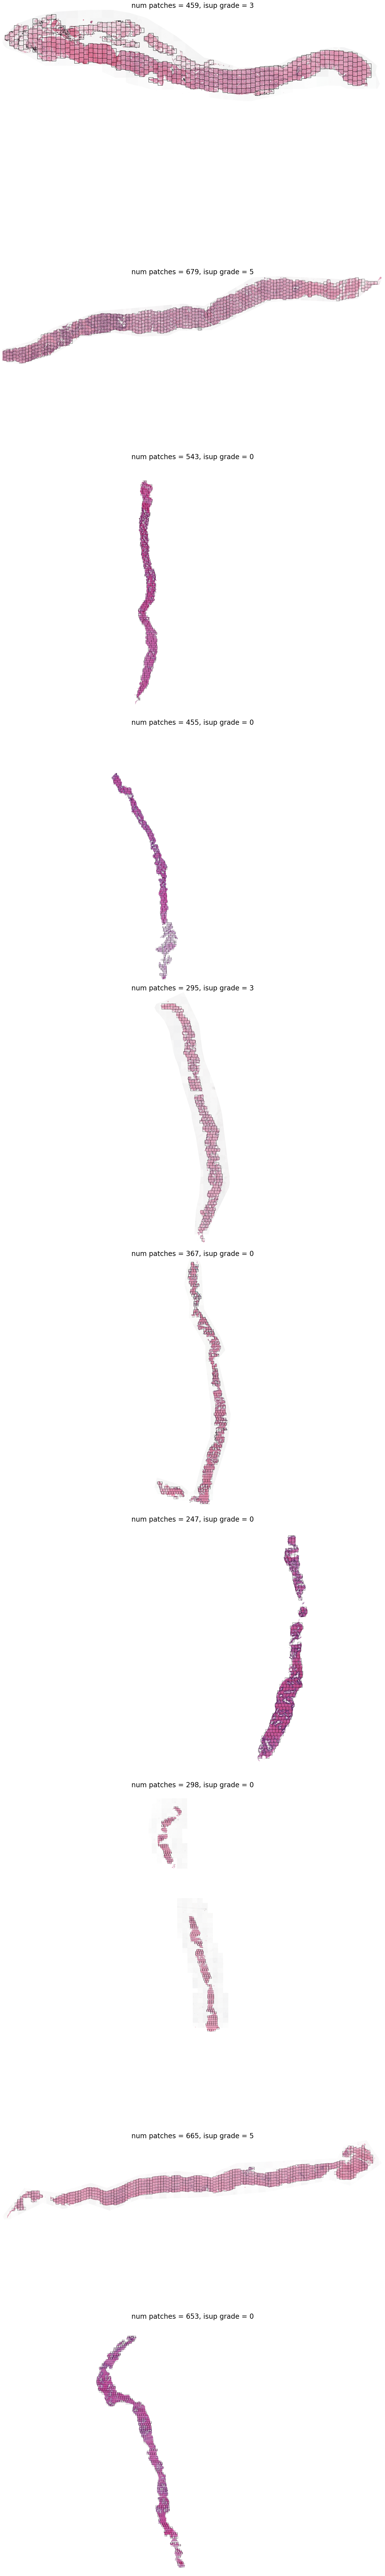

In [15]:
fig, axes = plt.subplots(10, 1, figsize=(20, 140))

patch_size = 256

for i, ax in enumerate(axes.reshape(-1)):
    image_path = input_path + data.image_id[i+500] + '.tiff'
    image = read_image(image_path, 1)
    
    coords = compute_coords(image,
                            patch_size=patch_size,
                            precompute=True,
                            min_patch_info=0.35,
                            min_axis_info=0.35,
                            min_consec_axis_info=0.35,
                            min_decimal_keep=0.7)
    
    # sort coords (high info -> low info)
    coords = sorted(coords, key= lambda x: x[0], reverse=False)
    for (v, y, x) in coords:
        end_point = (x, y)
        start_point = (x+patch_size, y+patch_size)
        image = cv2.rectangle(image, start_point, end_point, 2, 14)
    
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(
        "num patches = "+str(len(coords))+", isup grade = "+str(data.isup_grade[i+500]),
        fontsize=20)

plt.subplots_adjust(hspace=0.05, wspace=0.05)

### TensorFlow: Stitch patches together, using tf-operations and tf.data.Dataset
compute_coords(..., precompute=False) -> patch_image(..., coords)

In [16]:
def _patch_augment(patch, p=0.5):
    """Performs random rotation, random flip (u/d, l/r),
    and random transpose, based on probability p"""
    r1 = tf.random.uniform(
        shape=(4,), minval=0, maxval=1)
    r2 = tf.random.uniform(
        shape=(), minval=0, maxval=4, dtype=tf.int32)
    if r1[0] > (1-p):
        patch = tf.image.rot90(patch, k=r2)
    if r1[1] > (1-p):
        patch = tf.image.random_flip_left_right(patch)
    if r1[2] > (1-p):
        patch = tf.image.random_flip_up_down(patch)
    if r1[3] > (1-p):
        patch = tf.transpose(patch, (1, 0, 2))
    return patch

def _excess_coords_filtering(coords, sample_size, proportion=0.25):
    """filters out a portion of excessive coordinates.
    coordinates with higher values are filtered out.
    """
    if len(coords) > sample_size:
        c = tf.transpose(coords)
        v = tf.gather(c, 0)
        num = tf.cast(len(v), tf.float32)
        sample_size = tf.cast(sample_size, tf.float32)
        indices_reduced = int(tf.math.ceil(
            num * (1 - ((num - sample_size) / num) * proportion)
        ))
        v_argsort = tf.argsort(v)
        indices = tf.gather(v_argsort, tf.range(indices_reduced))
        indices = tf.sort(indices)
        coords = tf.gather(coords, indices)
    return coords

@tf.function
def patch_image(image, coords, sample_size=36, patch_size=256):

    l = tf.cast(tf.math.sqrt(tf.cast(sample_size, tf.float32)), tf.int32)
    
    coords = _excess_coords_filtering(coords, sample_size)
    # coords = tf.random.shuffle(coords)
    if len(coords) < sample_size:
        indices = tf.tile(
            tf.range(len(coords)), [tf.math.ceil(sample_size/len(coords))])
        indices = indices[:sample_size]
    else:
        indices = tf.range(sample_size)

    coords = tf.gather(coords, indices)
    
    coords = tf.random.shuffle(coords) # Update: shuffle here instead
    
    patched_image = tf.zeros(
        [0, patch_size, patch_size, 3], dtype=tf.dtypes.uint8)

    for i in range(sample_size):
        y = tf.gather_nd(coords, [i, 1])
        x = tf.gather_nd(coords, [i, 2])
        shape = tf.shape(image)
        h = tf.gather(shape, 0)
        w = tf.gather(shape, 1)
        if y < 0: y = 0
        if x < 0: x = 0
        if y > h-patch_size: y = h-patch_size
        if x > w-patch_size: x = w-patch_size
            
        patch = tf.slice(
            image, 
            tf.stack([y, x, 0]), 
            tf.stack([patch_size, patch_size, -1]))

        patch = _patch_augment(patch)
        patched_image = tf.concat([
            patched_image, tf.expand_dims(patch, 0)], axis=0)
    
    patched_image = tf.reshape(patched_image, (-1, patch_size*l, patch_size, 3))
    patched_image = tf.transpose(patched_image, (0, 2, 1, 3))
    patched_image = tf.reshape(patched_image, (patch_size*l, patch_size*l, 3))
        
    return patched_image


np.random.seed(42)
image_paths = glob.glob(input_path + '*')
np.random.shuffle(image_paths)

dataset = tf.data.Dataset.from_tensor_slices(image_paths)

dataset = dataset.map(
    lambda x: tf.py_function(
        func=read_image,
        inp=[x],
        Tout=[tf.uint8]), 
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.map(
    lambda x: tf.py_function(
        func=compute_coords,
        inp=[x],
        Tout=[tf.uint8, tf.int32]
    ),
    num_parallel_calls= tf.data.experimental.AUTOTUNE)

dataset = dataset.map(
    patch_image, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.batch(4)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

for x in dataset.take(1):
    pass

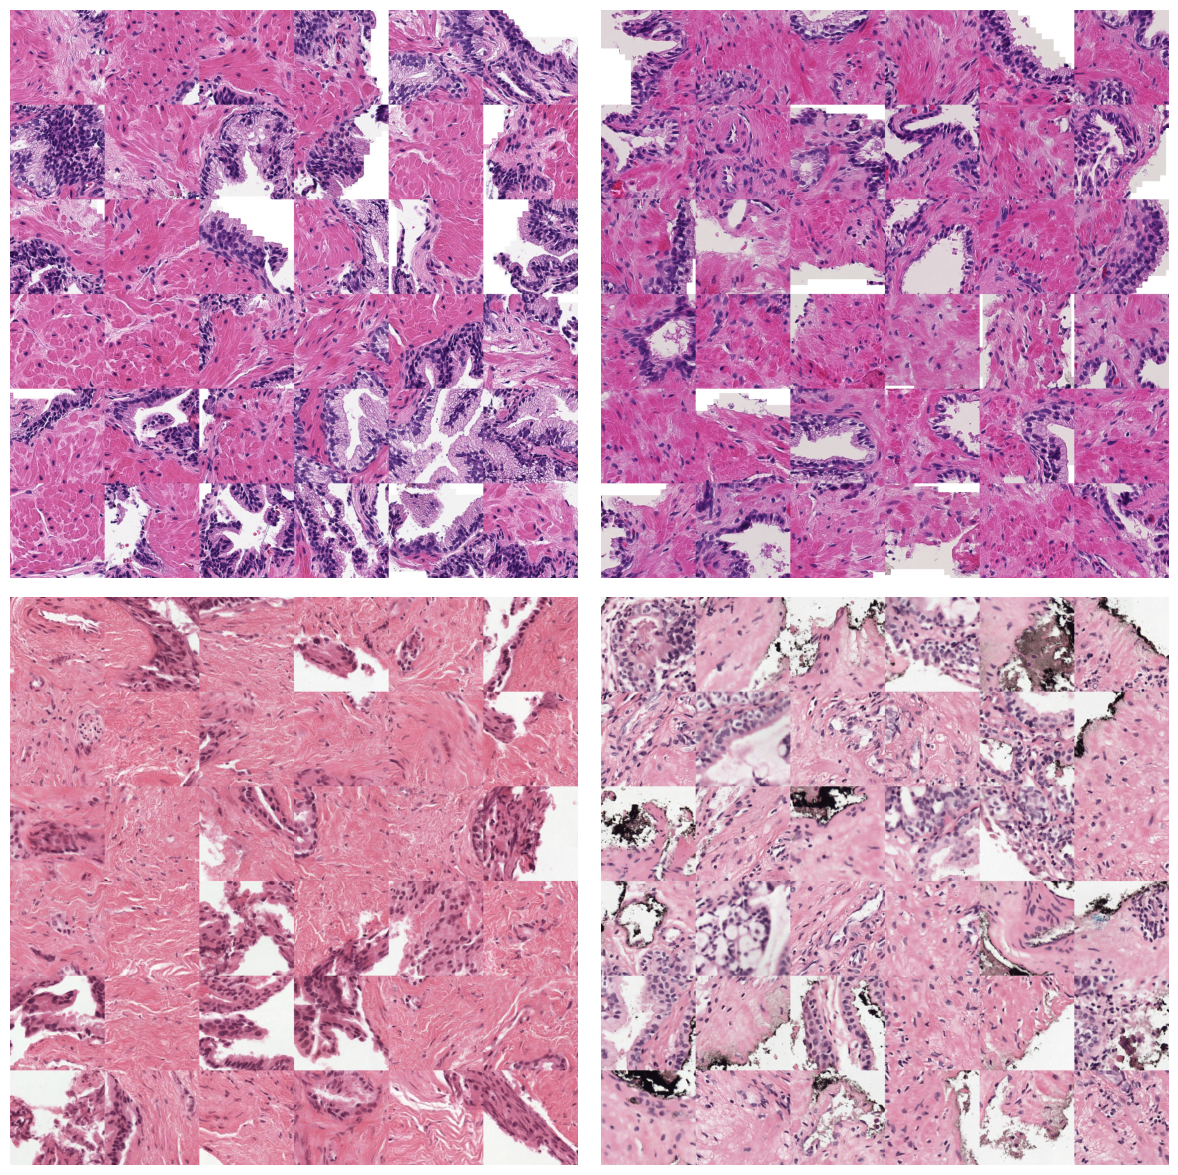

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(x.numpy()[i])
    ax.axis('off')
    
plt.subplots_adjust(hspace=0.035, wspace=0.035)